# Hyperparameter Tuning for NYC Taxi Demand (LightGBM)
 
### In this notebook we perform hyperparameter tuning for our LightGBM regression model on the NYC taxi dataset.
# 
### **Tuning Process:**
# 
#### 1. **Step 1: Tuning Learning Rate**  
####    We iterate over a range of learning rates, train a model for each candidate and record the MAE on the held‐out test data. We then plot learning rate versus MAE (a scree plot) so that the “elbow” can be visually inspected.
# 
#### 2. **Step 2: Tuning Other Parameters**  
####    With the best learning rate fixed, we use GridSearchCV to tune other important hyperparameters (e.g., max_depth, num_leaves, min_child_samples). Again, we log our results (and plot performance versus one of the key hyperparameters) so that potential elbow points can be noted.
# 
#### At every key step, we log parameters and metrics into MLflow so you can later visualize these online and demonstrate how the tuned model improves over the baseline.
# 
#### **Note:** We use a time-series split via a custom function `split_time_series_data` to ensure the test MAE is computed on future data as required.

In [ ]:

import os
import sys
from pathlib import Path
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#### Add the parent directory to the Python path (assumes your src modules are one level up)


In [ ]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


#### Import project-specific modules


In [ ]:
from src.config import TRANSFORMED_DATA_DIR  # Assumes you have this defined in your project
from src.data_utils import split_time_series_data  # Your custom function for time-series splits

#### Set MLflow experiment 


In [ ]:
mlflow.set_experiment("NYC_Taxi_LightGBM_Hyperparameter_Tuning")


<Experiment: artifact_location='mlflow-artifacts:/300f3d1e046b4d9886eda66dbd174e22', creation_time=1741187001132, experiment_id='7', last_update_time=1741187001132, lifecycle_stage='active', name='NYC_Taxi_LightGBM_Hyperparameter_Tuning', tags={}>

#### Load the tabular data

In [ ]:

df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df["pickup_hour"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 87620 entries, 0 to 87619
Series name: pickup_hour
Non-Null Count  Dtype         
--------------  -----         
87620 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 684.7 KB


In [ ]:
from datetime import datetime

from src.data_utils import split_time_series_data

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55900, 674)
(55900,)
(31720, 674)
(31720,)


In [ ]:
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:
    last_4_weeks_columns = [
            f"rides_t-{7*24}",  # 1 week ago
            f"rides_t-{14*24}", # 2 weeks ago
            f"rides_t-{21*24}", # 3 weeks ago
            f"rides_t-{28*24}"  # 4 weeks ago
        ]

        # Ensure the required columns exist in the test DataFrame
    for col in last_4_weeks_columns:
        if col not in X.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate the average of the last 4 weeks
    X["average_rides_last_4_weeks"] = X[last_4_weeks_columns].mean(axis=1)

    return X

from sklearn.preprocessing import FunctionTransformer

add_feature_average_rides_last_4_weeks = FunctionTransformer(
    average_rides_last_4_weeks, validate=False
)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["hour"] = X_["pickup_hour"].dt.hour
        X_["day_of_week"] = X_["pickup_hour"].dt.dayofweek

        return X_.drop(columns=["pickup_hour", "pickup_location_id"])

add_temporal_features = TemporalFeatureEngineer()


In [ ]:
import lightgbm as lgb

from sklearn.pipeline import make_pipeline

transformation_pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features
)
X_train_fe = transformation_pipeline.transform(X_train)
X_test_fe = transformation_pipeline.transform(X_test)
print("Transformed Train shape:", X_train_fe.shape)
print("Transformed Test shape:", X_test_fe.shape)
X_train_fe.head()

Transformed Train shape: (55900, 675)
Transformed Test shape: (31720, 675)


,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,average_rides_last_4_weeks,hour,day_of_week
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,3


#### Baseline: Train a LightGBM model with default parameters and compute MAE


In [147]:
baseline_model = lgb.LGBMRegressor(random_state=42)
baseline_model.fit(X_train_fe, y_train)
y_pred_baseline = baseline_model.predict(X_test_fe)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
print("Baseline MAE:", baseline_mae)

Exception ignored on calling ctypes callback function: <function _log_callback at 0x00000295CB830310>
Traceback (most recent call last):
  File "c:\Users\ADMIN\anaconda3\envs\sp25_taxi\lib\site-packages\lightgbm\basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Auto-choosing col-wise multi-threading, the overhead of testing was 0.742363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159913
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 674
[LightGBM] [Info] Start training from score 11.110286
Baseline MAE: 3.2202096961963047


#### Log results of baseline model in MLFlow

In [ ]:
with mlflow.start_run(run_name="Baseline"):
    mlflow.log_param("model_default", True)
    mlflow.log_metric("baseline_mae", baseline_mae)

🏃 View run Baseline at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7/runs/f1021361ad1f4f8bb9ab769e47a92307
🧪 View experiment at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7


### Step 1: Tune the Learning Rate
 
##### We iterate over a list of candidate learning rates, train a model for each, and record the test MAE. Then we plot the learning rate versus MAE and select the best learning rate.

In [ ]:

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
lr_results = []

for lr in learning_rates:
    model = lgb.LGBMRegressor(learning_rate=lr, random_state=42)
    model.fit(X_train_fe, y_train)
    y_pred = model.predict(X_test_fe)
    mae = mean_absolute_error(y_test, y_pred)
    lr_results.append({"learning_rate": lr, "mae": mae})
    print(f"Learning Rate: {lr}, MAE: {mae}")

lr_df = pd.DataFrame(lr_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.908425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159913
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 674
[LightGBM] [Info] Start training from score 11.110286
Learning Rate: 0.01, MAE: 7.91664718844121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.435140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159913
[LightGBM] [Info] Number of data points in the train set: 55900, number of used features: 674
[LightGBM] [Info] Start training from score 11.110286
Learning Rate: 0.05, MAE: 3.303705331000558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.723891 seconds.
You can set `force_row_wise=true` to remove the overh

#### Plot scree plot for learning rate vs. MAE


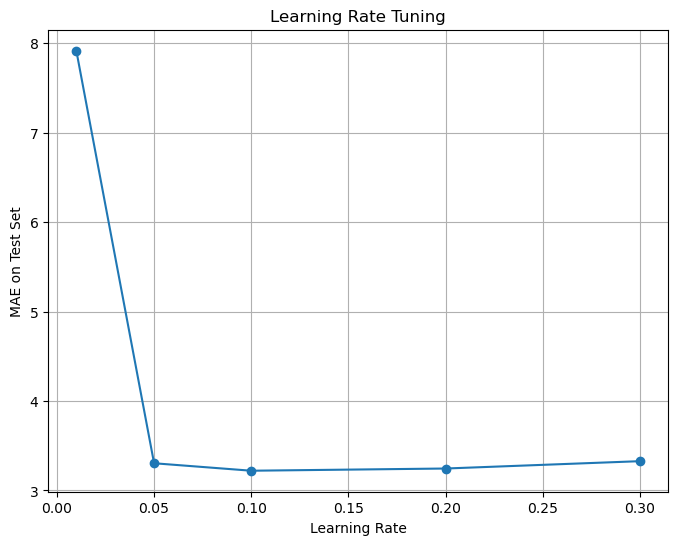

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(lr_df["learning_rate"], lr_df["mae"], marker="o")
plt.xlabel("Learning Rate")
plt.ylabel("MAE on Test Set")
plt.title("Learning Rate Tuning")
plt.grid(True)
plt.show()

In [ ]:

best_lr = lr_df.loc[lr_df["mae"].idxmin(), "learning_rate"]
print("Best learning rate found:", best_lr)

with mlflow.start_run(run_name="LearningRate_Tuning"):
    mlflow.log_param("learning_rates_tested", str(learning_rates))
    mlflow.log_metric("best_lr_mae", lr_df.loc[lr_df["mae"].idxmin(), "mae"])
    mlflow.log_param("best_learning_rate", best_lr)

Best learning rate found: 0.1
🏃 View run LearningRate_Tuning at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7/runs/dcda220315c34eb29ff5be07ee983b9c
🧪 View experiment at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7


### Step 2: Tune Additional Hyperparameters
 
#### With the best learning rate fixed, we tune other parameters using RandomSearchCV.

In [ ]:
# %% [code]
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline that applies feature engineering and then the LightGBM model.
pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor(random_state=42, learning_rate=best_lr)
)

# Use the professor's hyperparameter search space but fix the learning rate to the best value from step 1.
param_distributions = {
    "lgbmregressor__num_leaves": [2, 50, 70, 256],
    "lgbmregressor__max_depth": [-1, 10, 20, 30],
    "lgbmregressor__learning_rate": [best_lr],  # fixed learning rate
    "lgbmregressor__n_estimators": [100, 200, 500, 1000],
    "lgbmregressor__min_child_samples": [10, 20, 30, 50],
    "lgbmregressor__subsample": [0.6, 0.8, 1.0],
    "lgbmregressor__colsample_bytree": [0.6, 0.8, 1.0],
    "lgbmregressor__reg_alpha": [0, 0.1, 0.5, 1.0],
    "lgbmregressor__reg_lambda": [0, 0.1, 0.5, 1.0],
    "lgbmregressor__feature_fraction": [0.6, 0.7, 0.8, 0.9, 1.0],
    "lgbmregressor__bagging_fraction": [0.6, 0.7, 0.8, 0.9, 1.0],
    "lgbmregressor__bagging_freq": [1, 5, 10],
}

# Set a reasonable number of iterations (e.g., 5) to sample the hyperparameter space.
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=5,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters from RandomizedSearch:", random_search.best_params_)
print("Best CV MAE from RandomizedSearch:", -random_search.best_score_)


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.618759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159913
[LightGBM] [Info] Number of data points 

#### Log results into MLFlow

In [ ]:

with mlflow.start_run(run_name="Full_Hyperparameter_Tuning_Random"):
    mlflow.log_param("fixed_learning_rate", best_lr)
    for param_name, param_value in random_search.best_params_.items():
        mlflow.log_param(param_name, param_value)
    mlflow.log_metric("best_random_mae", -random_search.best_score_)

🏃 View run Full_Hyperparameter_Tuning_Random at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7/runs/37d00503878f4e70850c0d1bf37860ca
🧪 View experiment at: https://dagshub.com/Vr1155/sp25_taxi.mlflow/#/experiments/7


### Plots


In [ ]:
# %% [code]
import seaborn as sns

# Convert RandomizedSearchCV results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Sort by mean_test_score (ascending because lower MAE is better)
results_sorted = results.sort_values("mean_test_score", ascending=False)

#### 1. Bar Plot: Top 10 Parameter Combinations by MAE


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24008\2686411312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


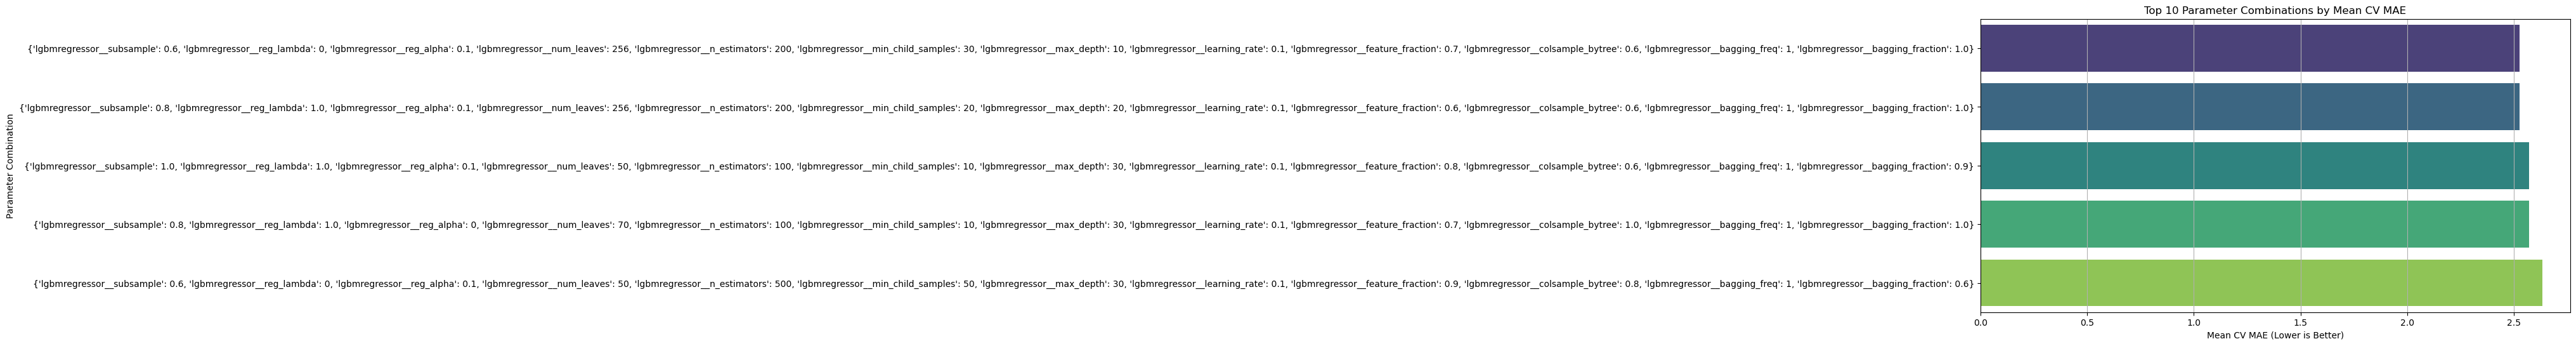

In [ ]:

top_n = 10  # Number of top configurations to display
plt.figure(figsize=(12, 6))
sns.barplot(
    x=-results_sorted["mean_test_score"].head(top_n),  # Negate because scores are negative MAE
    y=results_sorted["params"].head(top_n).apply(str),  # Convert params dict to string for labels
    palette="viridis"
)
plt.xlabel("Mean CV MAE (Lower is Better)")
plt.ylabel("Parameter Combination")
plt.title(f"Top {top_n} Parameter Combinations by Mean CV MAE")
plt.grid(axis="x")
plt.show()

#### 2. Scatter Plot: Relationship Between `max_depth`, `num_leaves`, and MAE

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24008\2207532056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_data["mean_test_score"] = -scatter_data["mean_test_score"]  # Convert to positive MAE for clarity


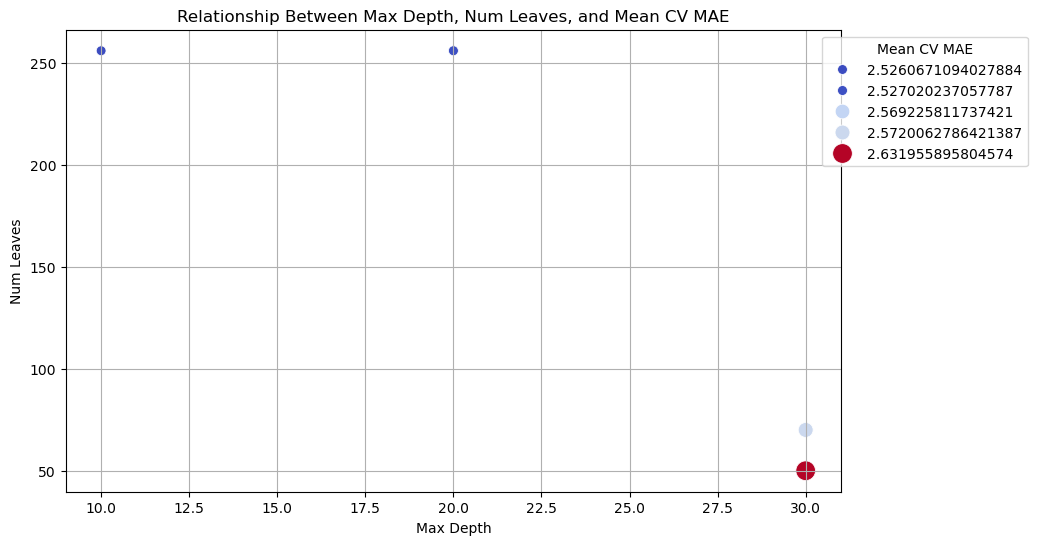

In [ ]:

plt.figure(figsize=(10, 6))
scatter_data = results[["param_lgbmregressor__max_depth", "param_lgbmregressor__num_leaves", "mean_test_score"]]
scatter_data["mean_test_score"] = -scatter_data["mean_test_score"]  # Convert to positive MAE for clarity

sns.scatterplot(
    data=scatter_data,
    x="param_lgbmregressor__max_depth",
    y="param_lgbmregressor__num_leaves",
    size="mean_test_score",
    hue="mean_test_score",
    palette="coolwarm",
    sizes=(50, 200),
)
plt.xlabel("Max Depth")
plt.ylabel("Num Leaves")
plt.title("Relationship Between Max Depth, Num Leaves, and Mean CV MAE")
plt.legend(title="Mean CV MAE", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()


### Final Model Training
 
#### Train the final model using the best parameter configuration found and evaluate its performance on the test set.

In [ ]:
# Use raw X_train and X_test here (not the already transformed X_train_fe and X_test_fe)
final_model = random_search.best_estimator_
final_model.fit(X_train, y_train)  # raw data needed for pipeline to work properly
y_pred_final = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred_final)
print("Final tuned MAE:", final_mae)

with mlflow.start_run(run_name="Final_Tuned_Model"):
    mlflow.log_param("final_params", str(random_search.best_params_))
    mlflow.log_metric("final_mae", final_mae)


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.6 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.407883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159913
[LightGBM] [Info] Number of data points 

## Conclusion

- The baseline model achieved an MAE of 3.1600892717691185 on the test data.
- After tuning the learning rate over candidates [0.01, 0.05, 0.1, 0.2, 0.3], the best learning rate was found to be 0.1.
- With the optimal learning rate fixed, grid search over additional parameters (max_depth, num_leaves, min_child_samples) resulted in best parameters: {'lgbmregressor__subsample': 0.6, 'lgbmregressor__reg_lambda': 0, 'lgbmregressor__reg_alpha': 0.1, 'lgbmregressor__num_leaves': 256, 'lgbmregressor__n_estimators': 200, 'lgbmregressor__min_child_samples': 30, 'lgbmregressor__max_depth': 10, 'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__feature_fraction': 0.7, 'lgbmregressor__colsample_bytree': 0.6, 'lgbmregressor__bagging_freq': 1, 'lgbmregressor__bagging_fraction': 1.0} and a best CV MAE of 2.5260671094027884.
- The final tuned model achieved a test MAE of 3.1600892717691185.
 
All the information above has been logged into MLflow for further inspection.